In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 设置gpu内存自增长
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 步骤

### 1. preprocessing data
### 2. build model
#### 2.1 encoder
#### 2.2 attention
#### 2.3 decoder
#### 2.4 loss & optimizer
#### 2.5 train
### 3. evaluation
#### 3.1 sentence -> translated results
#### 3.2 visualize results(attention)

## 1. 数据预处理

In [3]:
spa_en_file_path = './data_spa_en/spa.txt'

# 将unicode转换成ascii
import unicodedata
def unicode_to_ascii(s):   # 西班牙语有些特殊字符使用unicode表示，因此这里转成ascii码，减少词表大小
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')  # Mn 代表重音，此处将西班牙语的重音忽略掉
    
en_sentence = 'I\'m next.'
sp_sentence = 'Me toca a mí.'

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

I'm next.
Me toca a mi.


In [4]:
# 对每个句子进行预处理
import re
def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r'([?.!,¿¡])', r' \1 ', s)   # 将句子s中所有的标点符号前后都加上空格 
    s = re.sub(r'[" "]+', ' ', s)           # 多余的空格变成一个空格
    s = re.sub(r'[^a-zA-Z?.!,¿¡]', ' ', s)  # 将除了字母标点符号之外的字符都替换成空格 
    s = s.rstrip().strip()   # 去掉前后空格
    s = '<start> ' + s + ' <end>'
    return s

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))

<start> i m next . <end>
<start> me toca a mi . <end>


In [5]:
# 读取文件并解析成dataset
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    sentence_pairs = [
        (preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs
    ]
    return zip(*sentence_pairs)

en_dataset, sp_dataset = parse_data(spa_en_file_path)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [6]:
# 文本 -> id
def tokenizer(lang):
    lang_tokenizer = keras.preprocessing.text.Tokenizer(num_words=None, filters='', split=' ')
    lang_tokenizer.fit_on_texts(lang)    # 生成词表
    tensor = lang_tokenizer.texts_to_sequences(lang)  # 将text转成id
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  # 做padding
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[0:30000])    # 先去前30000个数据，看看模型是否能快速拟合，验证完之后用整个数据集训练
output_tensor, output_tokenizer = tokenizer(en_dataset[0:30000])

def max_length(tensor):
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)

16 11


In [7]:
# 切分训练集和数据集
from sklearn.model_selection import train_test_split
input_train, input_eval, output_train, output_eval = train_test_split(input_tensor, output_tensor, test_size=0.2)  # 将20%的数据作为测试集
len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [8]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        dataset = dataset.shuffle(30000)
    dataset = dataset.repeat(epochs).batch(batch_size, drop_remainder=True)
    return dataset

batch_size = 64
epochs = 20
train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1, False)

In [9]:
x = 1
y = 1
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)
    print(x)
    print(y)

(64, 16) (64, 11)
tf.Tensor(
[[  1 149   9 ...   0   0   0]
 [  1 737  18 ...   0   0   0]
 [  1  75  16 ...   0   0   0]
 ...
 [  1   6  46 ...   0   0   0]
 [  1  13 336 ...   0   0   0]
 [  1 310  35 ...   0   0   0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1    4  133  727    3    2    0    0    0    0    0]
 [   1   22   32    6   75    3    2    0    0    0    0]
 [   1  195    8  182    3    2    0    0    0    0    0]
 [   1   16   23 3271    3    2    0    0    0    0    0]
 [   1   10   11    9 1701  191    3    2    0    0    0]
 [   1   16   30   12   63    5    3    2    0    0    0]
 [   1  584    3   32   11  129   44    7    2    0    0]
 [   1  486   25   22   20    3    2    0    0    0    0]
 [   1  597    8   13  265    3    2    0    0    0    0]
 [   1   60   24   16  634    7    2    0    0    0    0]
 [   1    4   18 2877  148    3    2    0    0    0    0]
 [   1    4   18   39   54    6   49    5    3    2    0]
 [   1  351   33 1633    3    2    0    0 

## 2. 构建模型

In [10]:
# 定义一些超参数
embedding_units = 256
units = 1024    # RNN的units数量
input_vocab_size = len(input_tokenizer.word_index) + 1  # input_tokenizer.word_index：一个单词到的字典
output_vocab_size = len(output_tokenizer.word_index) + 1

### 2.1 Encoder构建

In [11]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        # gru时lstm的变种，认为遗忘门 = 1 - 输入门
        self.gru = keras.layers.GRU(self.encoding_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        
    def call(self, x, hidden):   # hidden: 初始化的隐含状态，由initialize_hidden_state函数获取
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

encoder = Encoder(input_vocab_size, embedding_units, units, batch_size)


sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)
print('sample_output.shape: ', sample_output.shape)
print('sample_hidden.shape: ', sample_hidden.shape)

sample_output.shape:  (64, 16, 1024)
sample_hidden.shape:  (64, 1024)


### 2.2 attention构建

In [12]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    
    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: (batch_size, units)
        # encoder_outputs.shape: (batch_size, length, units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)    # decoder_hidden.shape -> (batch_size, 1, units)
        # before V, shape(batch_size, length, units)
        # after V, shape(batch_size, length, 1) 
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) + self.W2(decoder_hidden_with_time_axis)
            )
        )
        # attention_weights.shape: (batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector.shape: (batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        # context_vector.shape: (batch_size, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

attention_model = BahdanauAttention(10)
attention_result, attention_weights = attention_model(sample_hidden, sample_output)
print('attention_results.shape: ', attention_result.shape)
print('attention_weights.shape: ', attention_weights.shape)

attention_results.shape:  (64, 1024)
attention_weights.shape:  (64, 16, 1)


### 2.3 Decoder构建

In [13]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.decoding_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)
    
    def call(self, x, hidden, encoding_output):
        # context_vector.shape: (batch_size, units)
        # attentino_weights.shape: (batch_size, length, 1)
        context_vector, attention_weights = self.attention(hidden, encoding_output)
        
        # before embedding x.shape: (batch_size, 1)
        # after embedding x.shape: (batch_size, 1, embedding_units)
        x = self.embedding(x)
        
        combined_x = tf.concat([
            tf.expand_dims(context_vector, 1),
            x
        ], axis=-1)
        
        # output.shape: (batch_size, 1, decoding_units)
        # state.shape: (batch_size, decoding_units)
        output, state = self.gru(combined_x)
        
        # output.shape: (batch_size, decoding_units)
        output = tf.reshape(output, (-1, output.shape[-1]))
        
        # output.shape(batch_size, vocab_size)
        output = self.fc(output)
        
        return output, state, attention_weights

decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)
decoder_output, decoder_hidden, decoder_attention_weights = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
print('decoder_output.shape: ', decoder_output.shape)
print('decoder_hidden.shape: ', decoder_hidden.shape)
print('decoder_attention_weights.shape: ', decoder_attention_weights.shape)

decoder_output.shape:  (64, 4935)
decoder_hidden.shape:  (64, 1024)
decoder_attention_weights.shape:  (64, 16, 1)


### 2.4 loss & optimizer

In [14]:
optimizer = keras.optimizers.Adam()

loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# 计算单步损失函数
def loss_function(real, pred):
    # mask: 将padding计算得出的loss去掉
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)   # mask: boolean -> loss_.dtype 以便loss_和mask做乘法去掉padding所计算出来的loss
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

### 2.5 train

In [15]:
# 计算多步损失函数
@tf.function
def train_step(input, target, encoding_hidden):
    loss = 0.0
    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(input, encoding_hidden)
        decoding_hidden = encoding_hidden
        for t in range(0, target.shape[1]-1):
            decoding_input = tf.expand_dims(target[:, t], 1)
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
            loss += loss_function(target[:, t+1], predictions)
    
    batch_loss = loss / int(target.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [16]:
# # 此处为证明(batch_size, vocab_size)与(batch_size, id)可以计算SparseCategoricalCrossentropy,其中vocab_size为词表大小(batch_size， vocab_size)代表长度为vocab_size的one_hot编码，(batch_size, id)表示一个词所代表的id
# # x_test, y_test
# encoding_hidden = encoder.initialize_hidden_state()
# encoding_outputs, encoding_hidden = encoder(x_test, encoding_hidden)
# decoding_hidden = encoding_hidden

# decoding_input = tf.expand_dims(y_test[:, 1], 1)
# predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_outputs)
# print('predictions: ', predictions)
# print('target[:, 2]', y_test[:, 2])
# loss = loss_function(y_test[:, 2], predictions)
# print('loss: ', loss)

In [17]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start_time = time.time()
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (input, target)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, encoding_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch: {}  Batch: {} Loss: {:.4f}'.format(epoch+1, batch, batch_loss.numpy()))
    print('Epoch: {} Loss: {:.4f}'.format(epoch+1, total_loss / steps_per_epoch))
    print('Time take for this epoch is {} second\n'.format(time.time()-start_time))


Epoch: 1  Batch: 0 Loss: 0.7973
Epoch: 1  Batch: 100 Loss: 0.3762
Epoch: 1  Batch: 200 Loss: 0.3103
Epoch: 1  Batch: 300 Loss: 0.2758
Epoch: 1  Batch: 400 Loss: 0.2650
Epoch: 1 Loss: 0.3284
Time take for this epoch is 54.25423073768616 second

Epoch: 2  Batch: 0 Loss: 0.2483
Epoch: 2  Batch: 100 Loss: 0.2406
Epoch: 2  Batch: 200 Loss: 0.2163
Epoch: 2  Batch: 300 Loss: 0.2045
Epoch: 2  Batch: 400 Loss: 0.1643
Epoch: 2 Loss: 0.2099
Time take for this epoch is 37.52070164680481 second

Epoch: 3  Batch: 0 Loss: 0.1641
Epoch: 3  Batch: 100 Loss: 0.1442
Epoch: 3  Batch: 200 Loss: 0.1387
Epoch: 3  Batch: 300 Loss: 0.1358
Epoch: 3  Batch: 400 Loss: 0.0928
Epoch: 3 Loss: 0.1337
Time take for this epoch is 37.53220462799072 second

Epoch: 4  Batch: 0 Loss: 0.0806
Epoch: 4  Batch: 100 Loss: 0.0961
Epoch: 4  Batch: 200 Loss: 0.1038
Epoch: 4  Batch: 300 Loss: 0.0881
Epoch: 4  Batch: 400 Loss: 0.0600
Epoch: 4 Loss: 0.0809
Time take for this epoch is 37.64337420463562 second

Epoch: 5  Batch: 0 Loss:

## 3 evaluation

In [51]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))
    input_sentence = preprocess_sentence(input_sentence)
    
    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_input, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
#     encoding_hidden = encoder.initialize_hidden_state()
    encoding_hidden = tf.zeros((1, units))
    
    encoder_outputs, encoding_hidden = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden
    
    # decoding_input.shape: (1, 1) (batch_size, length)
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_output):
        predictions, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoder_outputs)
        
        # attention_weights.shape: (batch_size, input_length, 1):(1, 16, 1) -> (input_length):(16)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()
        
        # predictions.shape: (batch_size, vocab_size): (1, 4935)
        prediction_id = tf.argmax(predictions[0]).numpy()
        result += output_tokenizer.index_word[prediction_id] + ' '
        
        if output_tokenizer.index_word[prediction_id] == '<end>':
            return result, input_sentence, attention_matrix
        
        decoding_input = tf.expand_dims([prediction_id], 0)
    return result, input_sentence, attention_matrix


def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')
    
    font_dict = {'fontsize': 14}
    ax.set_xticklabels(['']+input_sentence, fontdict=font_dict, rotation=90)
    ax.set_yticklabels(['']+predicted_sentence, fontdict=font_dict)
    plt.show()
    
def translate(input_sentence):
    result, input_sentence, attention_matrix = evaluate(input_sentence)
    print('Input: %s' % (input_sentence))
    print('Predicted_translation: %s' % (result))
    
    attention_matrix = attention_matrix[:len(result.split(' ')), :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), result.split(' '))
    

Input: <start> hace mucho frio aqui <end>
Predicted_translation: it s very cold here . <end> 


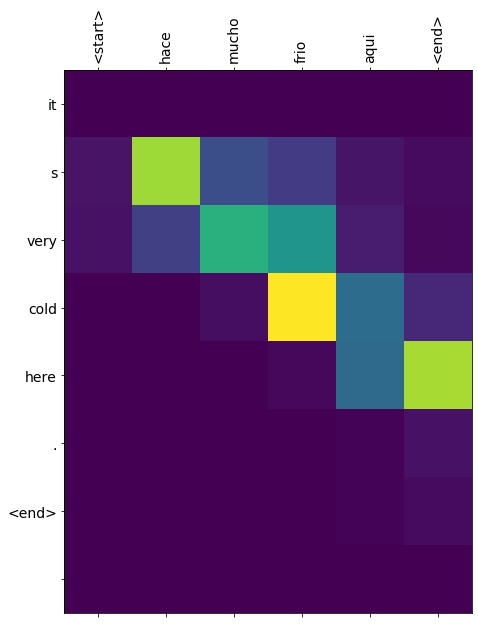

In [52]:
translate(u'hace mucho frío aquí')

Input: <start> te quiero <end>
Predicted_translation: i love you . <end> 


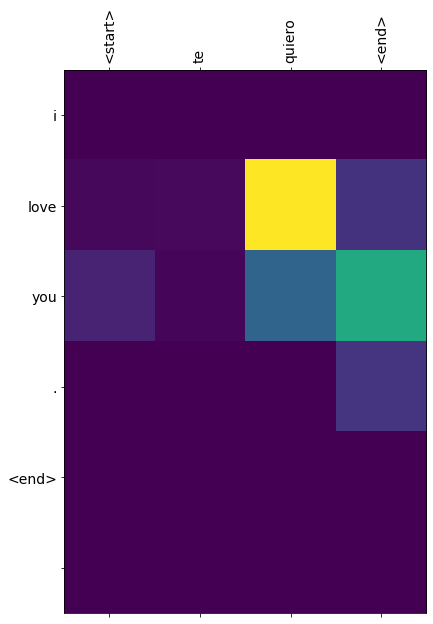

In [53]:
translate(u'Te quiero')

Input: <start> hijo de perro <end>
Predicted_translation: a dog is coming . <end> 


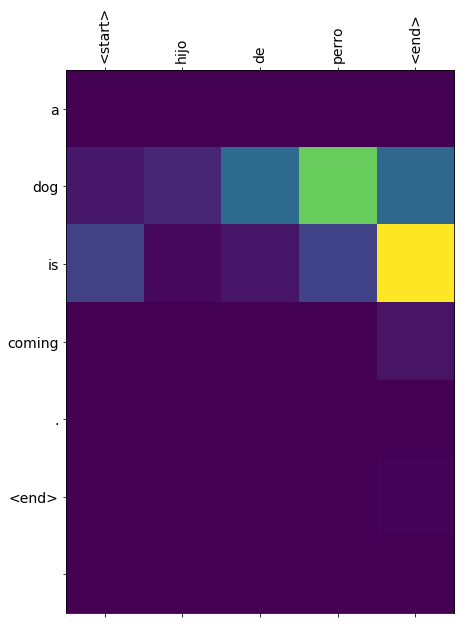

In [54]:
translate(u'hijo de perro')